# Tarea 2: ¿Es posible explicar la cantidad de billonarios en base al desarrollo país?  <a class="tocSkip"></a>







En 2006 *Daniel Treisman* publicó un artículo titulado [*Russia Billionaries*](https://pubs.aeaweb.org/doi/pdfplus/10.1257/aer.p20161068) en el cual conectó la cantidad de billonarios de un país con ciertos atributos económicos de los mismos. 

Su conclusión principal fue que Rusia tiene una cantidad de billonarios mayor que la que predicen los indicadores económicos

En esta tarea ustedes analizarán datos macroeconómicos para comprobar o refutar los hallazgos de *D. Treisman*

## Instrucciones generales 

1. Forme un grupo de **máximo tres estudiantes**
1. Versione su trabajo usando un **repositorio privado de github**. Agregue a sus compañeros y a su profesor (usuario github: phuijse) en la pestaña *Settings/Manage access*. No se aceptarán consultas de programación si no se cumple este requisito
1. Su tarea se evaluará en base al último commit antes de la fecha de entrega: **14:10 del Martes 15 de Junio de 2021**. La nota se calcula como ("pt totales" + 1)
1. [Sean leales y honestos](https://www.acm.org/about-acm/code-of-ethics-in-spanish), no copie ni comparta resultados con otros grupos

## Datos

Para esta tarea se les provee de un conjunto de datos `billonarios.csv` indexado por país con los siguientes atributos

- `nbillonarios`: La cantidad de billonarios del pais
- `logpibpc`: El logaritmo del Producto Interno Bruto (PIB) per capita del pais
- `logpob`: El logaritmo de la población del pais
- `gatt`: La cantidad de años que el pais está adherido al *General Agreement on Tariffs and Trade* (GATT)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.stats


## Modelo (1.0pt)

El objetivo principal de esta tarea es entrenar un modelo de regresión que prediga la cantidad de billonarios en función de los demás atributos

> El número de billonarios es una variable entera y no-negativa. 

Un modelo apropiado en este caso es la [regresión de Poisson](https://en.wikipedia.org/wiki/Poisson_distribution), donde definimos la probabilidad condicional para un pais $i$ como  

$$
p(y_i | x_i ) = \frac{\lambda_i^{y_i}}{y_i!} \exp \left ({-\lambda_i} \right)
$$

con intensidad

$$
\lambda_i = \exp \left (\theta_0 + \sum_{j=1}^M \theta_j x_{ij} \right)
$$

donde 

- $\theta$ es el vector de parámetros que deseamos ajustar 
- $y_i$ y $x_i$ son la cantidad de billonarios y el vector de atributos del país $i$, respectivamente

En base a este modelo se pide que ajusten $\theta$ mediante la maximización de la verosimilitud. 

$$
\begin{align}
\hat \theta &= \text{arg}\max_\theta \log \mathcal{L} (\theta) \nonumber \\ 
&= \text{arg}\max_\theta \log \prod_{i=1}^N  p(y_i | x_i) \nonumber \\
&= \text{arg}\max_\theta \sum_{i=1}^N \log p(y_i | x_i) \nonumber
\end{align}
$$

En particular:

1. Estudie y describa la distribución de Poisson en detalle. Muestre como varía la distribución en función de su parámetro $\lambda$, ¿Qué ocurre cuando $\lambda$ es pequeño? ¿Y cuando es grande?
1. Reemplace las expresiones y obtenga una expresión analítica para el logaritmo de la verosimilitud: $\log \mathcal{L}(\theta)$. Muestre la ecuación obtenida. HINT: Puede ignorar los términos que no dependan de $\theta$. Luego obtenga una expresión analítica para la primera derivada del logaritmo de la verosimilitud. Muestra la ecuación obtenida

### Respuesta
1. Es una distribuición probabilística de variable discreta que a partir de una frecuencia de ocurrencia media, determina la probabilidad de que ocurra un determinado número de eventos. Entre sus principales aplicaciones se encuentra el modelado de situaciones donde interesa conocer la frecuencia de un evento en un intervalo de tiempo. El parámetro $\lambda$ representa el número de veces que se espera que ocurra el fenómeno en un intervalo de tiempo. A medida que el valor de $\lambda$ crece, la curva de distrubución de probabilidad tiende a aplanarse, cuando $\lambda$ tiene un valor pequeño la curva será pronunciada, en cambio, si el valor de $\lambda$ es grande, la curva será mucho más aplanada. Como se aprecia en la imagen (Wikipedia).

<div>
<p style = 'text-align:center;'>
<img src="data/poisson.png" alt="JuveYell" width="300px">
</p>
</div>

2. 

Sea $ f_\theta(X_i) = \exp \left (\theta_0 + \sum_{j=1}^M \theta_j x_{ij} \right)$

Reemplazando en la expresión de probabilidad, se obtiene la verosimilitud:

$$
\mathcal{L}(\theta) = \frac{f_\theta(X_i)^{y_i}}{y_i!} \exp \left ({-f_\theta(X_i)} \right)
$$

Luego, calculando el logaritmo de la verosimilitud:

$$
log(\mathcal{L}(\theta)) = ln(\frac{f_\theta(X_i)^{y_i}}{y_i!} \exp \left ({-f_\theta(X_i)} \right))
$$

$$
log(\mathcal{L}(\theta)) = {y_i}{f_\theta(X_i)} - exp(f_\theta(X_i)) - ln({y_i}!) 
$$

Dado que $ln({y_i}!)$ no depende de $\theta$ se puede ignorar. Luego, derivando la expresión obtenemos:

$$
\frac{d(log(\mathcal{L}(\theta)))}{d\theta} = {X_i}{y_i} - {X_i}exp(f_\theta(X_i))
$$

## Implementación (1.5pt)

1. Implemente el logaritmo de la verosimilitud y su derivada usando `numpy`. Utilice operaciones vectoriales (prohibido usar `for` para iterar en los países)
1. Implemente una rutina que encuentre el vector de parámetros óptimo en base a `scipy.optimize.minimize` 
1. Implemente una rutina que calcule el pseudo coeficiente de correlación
$$
R^2 = \frac{\log \mathcal{L} (\hat \theta_0) - \log \mathcal{L} (\hat \theta) }{\log \mathcal{L} (\hat \theta_0)} \in [0, 1]
$$
donde $\log \mathcal{L} (\hat \theta)$ es el logaritmo de la verosimilitud de su mejor modelo y $\log \mathcal{L} (\hat \theta_0)$ es el logaritmo de la verosimilitud de un modelo que tiene sólo el parámetro $\theta_0$
1. Implemente una rutina de bootstrap resampling para encontrar la distribución y los intervalos de confianza empíricos para $\theta$ y el pseudo coeficiente de correlación


### Respuesta

1. Implementación del logaritmo de la verosimilitud y su derivada.

In [2]:
# Modelo de Poisson
def poisson(theta, X):
    f = theta[0] + np.sum(theta[1:]*X, axis=1)     
    return np.exp(f)

# Logaritmo de verosimilitud (función de costo)
def log_verosimilitud(theta, *args):
    X, Y = args
    lambd = poisson(theta, X)
    # Se agrega signo negativo ya que se busca minimizar
    return -np.sum(Y*(theta[0] + np.sum(theta[1:]*X, axis=1)) - lambd, axis=0)
    
    
# Derivada de la función de costo
def derivada_logvs(theta, *args):
    X, Y = args
    N = len(Y)
    lambd = poisson(theta, X)
    X1 = np.concatenate((np.ones(shape=(N, 1)), X), axis=1)
    a = Y - lambd
    return -np.sum(a[:,np.newaxis]*X1, axis=0)

2. Implementación de rutina que encuentra el vector de parámetros óptimo.

In [3]:
bill_df = pd.read_csv("data/billonarios.csv")
X = bill_df.loc[:,"logpibpc":"gatt"].values
Y = bill_df["nbillonarios"].values

display(bill_df)


# Solución inicial
D = X.shape[1]
theta_init = np.zeros(D+1)

best_theta = np.zeros_like(theta_init)

# Mejor valor de theta
res = scipy.optimize.minimize(fun=log_verosimilitud, # Función de costo
                              x0=theta_init, # Valor inicial de theta
                              method='BFGS', # Método de optimización
                              jac=derivada_logvs, # Derivada de la función de costo
                              args=(X, Y), # Datos
                              tol=1e-1)
res

,pais,nbillonarios,logpibpc,logpob,gatt
0,United States,469,10.786021,19.532846,60
1,Canada,25,10.743365,17.319439,0
2,"Bahamas, The",0,10.072139,12.760934,0
3,Aruba,0,10.223734,11.526276,0
4,Bermuda,0,11.446847,11.086334,0
...,...,...,...,...,...
192,"Micronesia, Fed. Sts.",0,7.824408,11.556923,0
193,Samoa,0,8.124372,12.119665,15
194,"Hong Kong SAR, China",26,10.356964,15.755374,22
195,Puerto Rico,0,10.122557,15.140160,60


      fun: -3459.0919420591144
 hess_inv: array([[ 3.70673787e-01, -1.56596079e-02, -1.21954009e-02,
         3.44556737e-04],
       [-1.56596079e-02,  1.19955356e-03,  2.83958452e-04,
        -3.65266526e-05],
       [-1.21954009e-02,  2.83958452e-04,  5.19156433e-04,
        -8.08162328e-06],
       [ 3.44556737e-04, -3.65266526e-05, -8.08162328e-06,
         3.60224315e-06]])
      jac: array([0.00158987, 0.01627308, 0.03621586, 0.08064455])
  message: 'Optimization terminated successfully.'
     nfev: 26
      nit: 14
     njev: 26
   status: 0
  success: True
        x: array([-2.90496309e+01,  1.08385813e+00,  1.17136634e+00,  5.96771244e-03])

3. Implementación de rutina que calcule el pseudo coeficiente de correlación.

In [4]:
# Modelo de Poisson modificado con theta[0] como unico parámetro
def modif_poisson(theta):   
    return np.exp(theta)

# Logaritmo de verosimilitud modificado
def modif_log_verosimilitud(theta, *args):
    X, Y = args
    lambd = modif_poisson(theta)
    # Se agrega signo negativo ya que se busca minimizar
    return np.sum(Y*(theta) - lambd, axis=0)

# Logaritmo del facotrial de y
def log_yfact(y):
    i=0
    final=0
    for i in range(len(y)):
        if y[i]!=0:
            c = np.linspace(1, y[i],y[i])
            final=np.sum(np.log(c))+final

    return final



1. Implementación de rutina de bootstrap resampling para encontrar la distribución y los intervalos de confianza empíricos para $\theta$ y el pseudo coeficiente de correlación.

In [5]:
# Pseudo coeficiente de correlación
def pseudo_coef(theta_best, X, Y):
    R2 = (modif_log_verosimilitud(theta_best[0], X, Y) - (-log_verosimilitud(theta_best, X, Y)))/(modif_log_verosimilitud(theta_best[0], X, Y)-log_yfact(Y))
    return R2

#bootstrap resampling
def resampling(x, y):
    size = len(x)
    idx = np.random.choice(size, size=size, replace=True)
    return x[idx], y[idx]

def boostrap_poisson(x, y, T):
    params = pd.DataFrame(columns=['best_theta'], index=np.arange(T))
    for t in range(T):
        res_boostrap = scipy.optimize.minimize(fun=log_verosimilitud, # Función de costo
                              x0=theta_init, # Valor inicial de theta
                              method='BFGS', # Método de optimización
                              jac=derivada_logvs, # Derivada de la función de costo
                              args=(resampling(X, Y)), # Datos
                              tol=1e-1)
        params.iloc[t, :] = [res_boostrap.x]
    return params

boostrap_params = boostrap_poisson(X, Y, T=1000)

print("\nPseudo Coeficiente de correlación")
display(pseudo_coef(res.x,X,Y))

print("\nResultados del Boostrap")
display(boostrap_params)




Pseudo Coeficiente de correlación


0.9879439632534623


Resultados del Boostrap


,best_theta
0,"[-29.760276554707424, 1.0713497283003193, 1.19..."
1,"[-23.703153023218032, 0.8462608128669322, 1.01..."
2,"[-28.974351621883635, 1.0627939573939071, 1.14..."
3,"[-22.683794456508682, 0.9886143235122546, 0.88..."
4,"[-24.14602670853206, 0.9826375094813921, 0.956..."
...,...
995,"[-29.259425954731384, 1.1657942780194932, 1.16..."
996,"[-25.74216961185999, 0.9529056172216517, 1.056..."
997,"[-29.237935444260117, 1.1416708413571248, 1.15..."
998,"[-28.904180738148344, 1.1698002821944786, 1.12..."


In [11]:
# Intervalo de confianza

def Intervalo(Valor_X):
    r_bootstrap = boostrap_params.iloc[:, 0]
    params = scipy.stats.linregress(Valor_X, Y)
    fig, ax = plt.subplots(figsize=(7, 6), tight_layout=True)
    media=r_bootstrap.mean()
    for i in range(len(r_bootstrap)):
        ax.hist(r_bootstrap[i], bins=20, density=True, color = "skyblue")

    hist_val, hist_lim, _ = ax.hist(media, bins=20, density=True, color = "skyblue")
    ax.plot([params.rvalue]*2, [0, np.max(hist_val)], 'r-', lw=2)
    IC = np.percentile(media, [2.5, 97.5])
    ax.plot([IC[0]]*2, [0, np.max(hist_val)], 'k--', lw=2)
    ax.plot([IC[1]]*2, [0, np.max(hist_val)], 'k--', lw=2)
    print(f"Intervalo de confianza al 95% de r: {IC}")
    print(media)
    display(pseudo_coef(media,X,Y))



Intervalo de confianza al 95% de r: [-26.12981635   1.14380528]
[-2.82485532e+01  1.05404011e+00  1.15108354e+00  1.27163625e-03]


0.9872777318305217

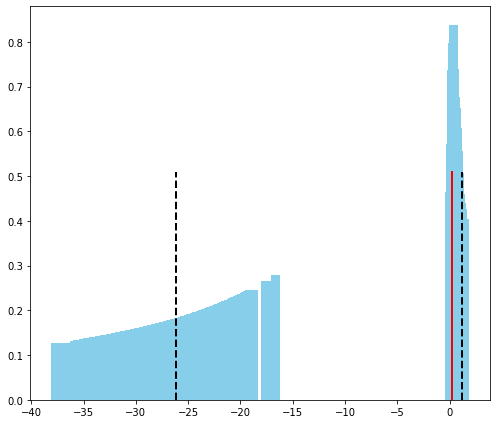

In [12]:
X1 = bill_df.loc[:,"logpibpc"].values
X2 = bill_df.loc[:,"gatt"].values
X3 = bill_df.loc[:,"logpob"].values
Intervalo(X3)


## Resultados (3pt)

1. Compare los métodos `CG`, `BFGS`, `Nelder-mead` y `Powell` en términos del vector de parámetros obtenido, la log verosimilitud alcanzada, el pseudo coeficiente de correlación alcanzado, el número de iteraciones necesarias para converger y el tiempo total para converger. Seleccione uno de los métodos para contestar los siguientes puntos
1. Muestre las distribuciones empíricas de los parámetros y del pseudo coeficiente de correlación. ¿Cuáles parámetros tienen $\theta$ significativamente distinto de cero? ¿Cuál es el intervalo de confianza al 95% del $R^2$? En base a esto ¿Qué puede decir sobre su modelo?
1. Prediga la cantidad de billonarios de cada país usando su modelo. Gráfique el error entre la cantidad de billonarios predicha y la cantidad de billonarios real. El gráfico debe mostrar los paises ordenados de mayor a menor **error absoluto**.  Analice ¿Cuáles son los 5 países con mayor error en la predicción? ¿Cuáles países tienen un exceso de billonarios? ¿Cúales paises tienen menos billonarios de lo esperado? ¿Qué puede decir sobre Rusia?



## 1 .-

In [13]:
#Comparación métodos de entrenamiento 

def show_results(params_vec):
    print("Vector de parámetros: {}".format(params_vec.x))
    print("Éxito del test: {}".format(params_vec.success))
    print("Mensaje: {}".format(params_vec.message))
    print("Número de evaluaciones: {}".format(params_vec.nfev))
    print("Número de iteraciones: {}".format(params_vec.nit))
    

def run_test(method):
    res = scipy.optimize.minimize(fun=log_verosimilitud, # Función de costo
                              x0=theta_init, # Valor inicial de theta
                              method=method, # Método de optimización
                              jac=derivada_logvs, # Derivada de la función de costo
                              args=(X, Y), # Datos
                              tol=1e-1)
    return res




print("****** RESULTADOS DE CADA MÉTODO *******")
#Método CG
print("\nMétodo CG")
show_results(run_test('CG'))

#Método BFGS
print("\nMétodo BFGS")
show_results(run_test('BFGS'))
#Nelder-mead
print("\nMétodo Nelder-mead")
show_results(run_test('Nelder-mead'))

#Powell
print("\nMétodo Powell")
show_results(run_test('Powell'))



****** RESULTADOS DE CADA MÉTODO *******

Método CG
Vector de parámetros: [-2.90353557e+01  1.08325169e+00  1.17089714e+00  5.98108445e-03]
Éxito del test: True
Mensaje: Optimization terminated successfully.
Número de evaluaciones: 502
Número de iteraciones: 207

Método BFGS
Vector de parámetros: [-2.90496309e+01  1.08385813e+00  1.17136634e+00  5.96771244e-03]
Éxito del test: True
Mensaje: Optimization terminated successfully.
Número de evaluaciones: 26
Número de iteraciones: 14

Método Nelder-mead
Vector de parámetros: [-0.04772606  0.00208631  0.04661695  0.03505848]
Éxito del test: True
Mensaje: Optimization terminated successfully.
Número de evaluaciones: 130
Número de iteraciones: 76

Método Powell
Vector de parámetros: [-0.85410192  0.18574653 -0.02864048  0.03242359]
Éxito del test: True
Mensaje: Optimization terminated successfully.
Número de evaluaciones: 127
Número de iteraciones: 3


C:\Users\rszh9\anaconda3\lib\site-packages\scipy\optimize\_minimize.py:517: RuntimeWarning: Method Nelder-mead does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,
C:\Users\rszh9\anaconda3\lib\site-packages\scipy\optimize\_minimize.py:517: RuntimeWarning: Method Powell does not use gradient information (jac).
  warn('Method %s does not use gradient information (jac).' % method,


## 2 .-

Intervalo de confianza al 95% de r: [-26.12981635   1.14380528]
[-2.82485532e+01  1.05404011e+00  1.15108354e+00  1.27163625e-03]


0.9872777318305217

array([-2.90496309e+01,  1.08385813e+00,  1.17136634e+00,  5.96771244e-03])

0.9879439632534623

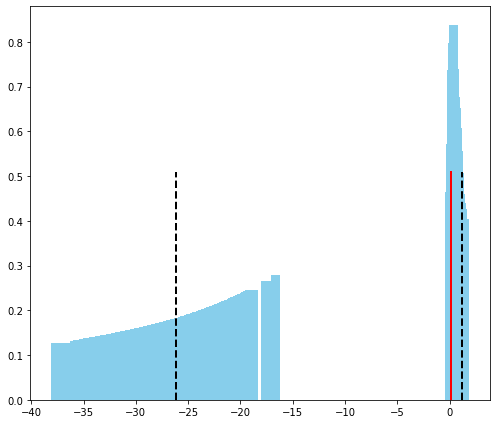

In [14]:
#Distribuciones empiricas de los parametros y pseudo coeficiente 
Intervalo(X1)
display(res.x)
display(pseudo_coef(res.x,X,Y))


Los parámetros que tienen 𝜃 destintos de cero para el obtenido a traves de vector de parámetros óptimos son:

$$ -29.0496309 , 1.08385813 , 1.17136634 $$
y de los obtenidos a traves de boostrap:
$$ -28.2020479 , 1.05719039 , 1.14536674 $$
Que se puede observar que son relativamente iguales los resultados.

Intervalo de confianza al 95% de r: 
$$ [-26.08675149 ,  1.13875351] $$
Esto significa que tenemos un 95% de confianza que los valores que obtendremos de 𝜃 estarán entre esos dos valores, que para nuestro caso a traves de los 𝜃 obtenidos se puede encontrar que efectivamente casi todos los parametros encontrados están entre esos intervalos a excepción de algunos que se escapan en poca medida, pero están dentro del error tolerable. Para nuestro modelo de predicción esto significa que se esta haciendo un buen trabajo y que el error que se obtendra al final será el minimo deseable.

## 3 .-

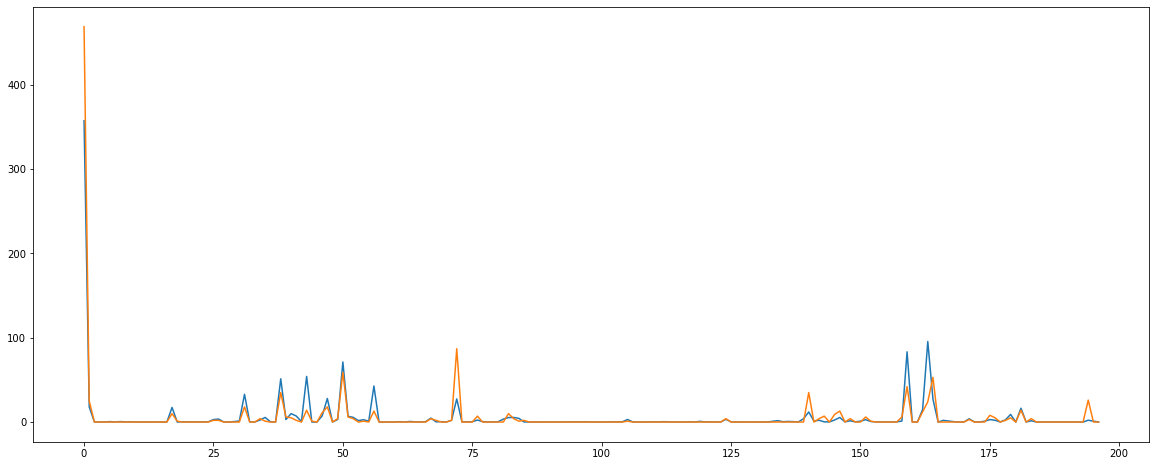

In [15]:
fig, ax = plt.subplots(figsize=(20,8))
x = np.arange(0,197,1)

ax.plot(x,poisson(res.x,X))
ax.plot(x,Y)


## Conclusiones (0.5pt)

Resuma sus principales hallazgos y comenté sobre las desafios encontrados al desarrollar esta tarea 